# Import & Load

In [286]:
# Let's import all the libraries used in this project

In [287]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

In [288]:
# Change plot style(color map)
plt.style.use('seaborn-v0_8-pastel')

In [289]:
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "harishkumardatalab/housing-price-prediction",
  "Housing.csv"
)

Using Colab cache for faster access to the 'housing-price-prediction' dataset.


This dataset provides comprehensive information for house price prediction, with 13 column names:

* **Price**: The price of the house.
* **Area**: The total area of the house in square feet.
* **Bedrooms**: The number of bedrooms in the house.
* **Bathrooms**: The number of bathrooms in the house.
* **Stories**: The number of stories in the house.
* **Mainroad**: Whether the house is connected to the main road (Yes/No).
* **Guestroom**: Whether the house has a guest room (Yes/No).
* **Basement**: Whether the house has a basement (Yes/No).
* **Hot water heating**: Whether the house has a hot water heating system (Yes/No).
* **Air conditioning**: Whether the house has an air conditioning system (Yes/No).
* **Parking**: The number of parking spaces available within the house.
* **Prefarea**: Whether the house is located in a preferred area (Yes/No).
 * **Furnishing status**: The furnishing status of the house (Fully Furnished, Semi-Furnished, Unfurnished).

In [290]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [349]:
# Looking at the data given, I suppose that the goal is to predict a house's price
# based on the given factors. Also, I think that the most important feature will
# be the area of the house, and the amount of bedrooms/bathrooms

# So, let's kickstart with EDA

# EDA

In [292]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [294]:
# So, we have some object-valued columns, which we won't be able to use for our
# models. Consequently, we need to transform them into numeric ones.

In [295]:
df['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [296]:
# As we have some data in object format, we should transform it into numbers
# (categories), mainroad, guestroom, basement, hotwaterheating, airconditioning,
# and prefarea have values of yes/no, which would be nicely changed to 0 and 1;
# at the same time, furnishingstatus has three types of values - 'furnished',
# 'semi-furnished', 'unfurnished', which also can be nicely transformed into
# numbers, because they'll have sense(like 0 - unfurnished, 0.5 - semi-furnished,
# and 1 - furnished)

In [297]:
df = df.replace({"yes": 1, "no": 0})
df['furnishingstatus'] = df['furnishingstatus'].map({
    'furnished': 1,
    'semi-furnished': 0.5,
    'unfurnished': 0
})

In [298]:
# Next, let's analyze data description
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000
mean,4766729.248,5150.541,2.965,1.286,1.806,0.859,0.178,0.350,0.046,0.316,0.694,0.235,0.465
std,1870439.616,2170.141,0.738,0.502,0.867,0.349,0.383,0.478,0.209,0.465,0.862,0.424,0.381
min,1750000.000,1650.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3430000.000,3600.000,2.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,4340000.000,4600.000,3.000,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
75%,5740000.000,6360.000,3.000,2.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000
max,13300000.000,16200.000,6.000,4.000,4.000,1.000,1.000,1.000,1.000,1.000,3.000,1.000,1.000


In [299]:
# It's quite inconvenient to look at data in scientific format, so let's move to
# familiar representations
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [300]:
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000
mean,4766729.248,5150.541,2.965,1.286,1.806,0.859,0.178,0.350,0.046,0.316,0.694,0.235,0.465
std,1870439.616,2170.141,0.738,0.502,0.867,0.349,0.383,0.478,0.209,0.465,0.862,0.424,0.381
min,1750000.000,1650.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3430000.000,3600.000,2.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,4340000.000,4600.000,3.000,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
75%,5740000.000,6360.000,3.000,2.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000
max,13300000.000,16200.000,6.000,4.000,4.000,1.000,1.000,1.000,1.000,1.000,3.000,1.000,1.000


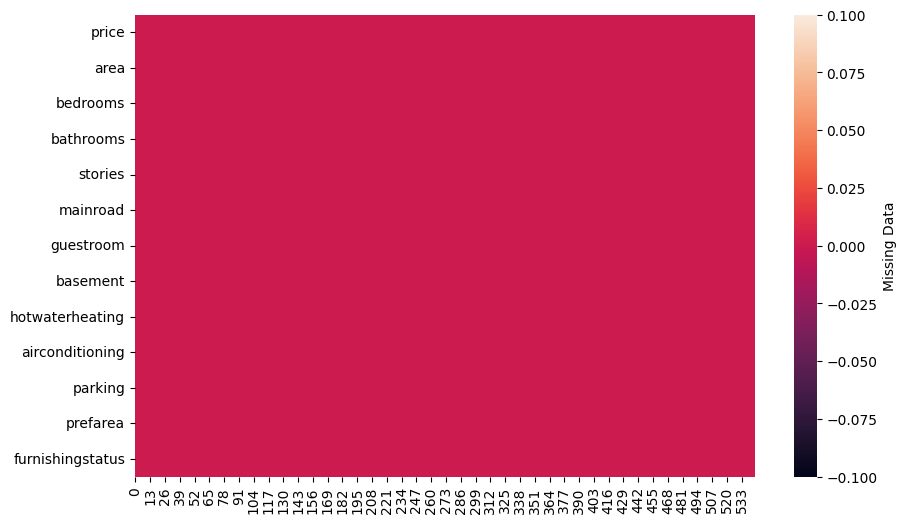

In [301]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cbar_kws={'label': 'Missing Data'});

In [302]:
# As far as I see, there are no missing values
# But I need to take a look at numbers

In [303]:
df.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [304]:
# As we've noticed in heatmap, there are no missing values - great

In [305]:
df.nunique()

,0
price,219
area,284
bedrooms,6
bathrooms,4
stories,4
mainroad,2
guestroom,2
basement,2
hotwaterheating,2
airconditioning,2


In [306]:
# The output shows that the features are in three main types: continuous
# (price, area), low-cardinality ordinal (bedrooms, bathrooms, stories, parking,
# furnishingstatus), and binary (mainroad, guestroom, etc.).

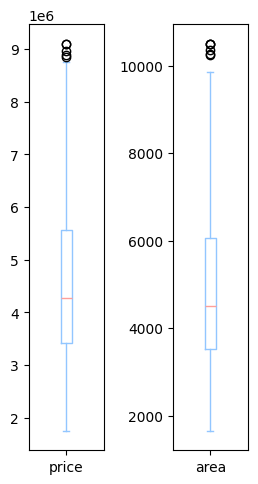

In [369]:
df[['price','area']].plot(
    kind='box',
    subplots=True,
    layout=(int(np.ceil(df.shape[1] / 5)), 5),
    figsize=(7, 14),
    sharex=False,
    sharey=False
)

plt.tight_layout()
plt.show()


In [308]:
# Judging by this boxplot, there are certainly outliers in the and the price of the houses.
# Let's find out outliers and delete them using IQR

In [309]:
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000,545.000
mean,4766729.248,5150.541,2.965,1.286,1.806,0.859,0.178,0.350,0.046,0.316,0.694,0.235,0.465
std,1870439.616,2170.141,0.738,0.502,0.867,0.349,0.383,0.478,0.209,0.465,0.862,0.424,0.381
min,1750000.000,1650.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3430000.000,3600.000,2.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,4340000.000,4600.000,3.000,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
75%,5740000.000,6360.000,3.000,2.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000
max,13300000.000,16200.000,6.000,4.000,4.000,1.000,1.000,1.000,1.000,1.000,3.000,1.000,1.000


In [ ]:
# Let's take a look at percentiles and calculate IQR

In [310]:
Q1_price = 3430000
Q3_price = 5740000

IQR_price = Q3_price - Q1_price
upper_price = Q3_price + 1.5*IQR_price
lower_price = Q1_price - 1.5*IQR_price

lower_price, upper_price

(-35000.0, 9205000.0)

In [311]:
# We calculate the outliers for price

In [312]:
Q1_area = 3600
Q3_area = 6360

IQR_area = Q3_area - Q1_area
upper_area = Q3_area + 1.5*IQR_area
lower_area = Q1_area - 1.5*IQR_area

lower_area, upper_area

(-540.0, 10500.0)

In [313]:
# We calculate the outliers for area

In [314]:
df = df[
    (df["price"] >= lower_price) & (df["price"] <= upper_price) &
    (df["area"] >= lower_area) & (df["area"] <= upper_area)
]

In [315]:
# Drop outliers

In [316]:
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,520.000,520.000,520.000,520.000,520.000,520.000,520.000,520.000,520.000,520.000,520.000,520.000,520.000
mean,4576773.923,4922.473,2.942,1.263,1.792,0.852,0.177,0.346,0.042,0.308,0.656,0.217,0.455
std,1594010.564,1824.287,0.732,0.466,0.864,0.356,0.382,0.476,0.201,0.462,0.841,0.413,0.379
min,1750000.000,1650.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3416000.000,3520.000,2.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,4270000.000,4500.000,3.000,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
75%,5573750.000,6070.000,3.000,2.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.500
max,9100000.000,10500.000,6.000,3.000,4.000,1.000,1.000,1.000,1.000,1.000,3.000,1.000,1.000


In [317]:
# Great, the maximum values and std dropped

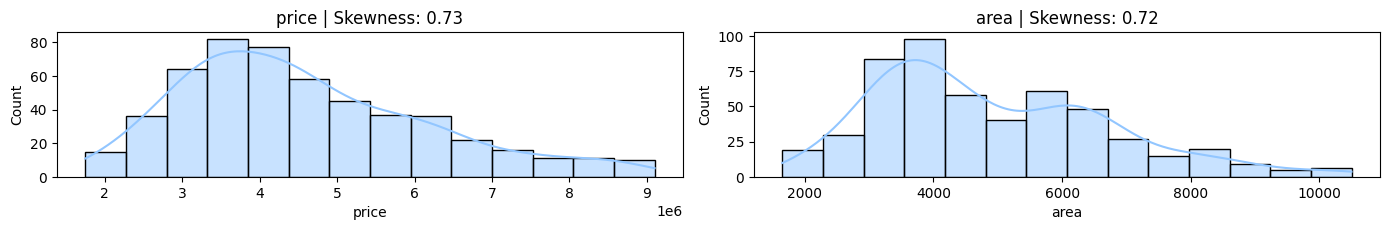

In [372]:
plt.figure(figsize=(14, len(['price','area']) * 2))
for idx, feature in enumerate(['price','area'], 1):
    plt.subplot(len(['price','area']), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

In [ ]:
# So, the data is a little skew even though we have deleted the outliers

In [ ]:
# I suppose that houses with a bigger area tend to be more expensive

<Axes: xlabel='price', ylabel='Count'>

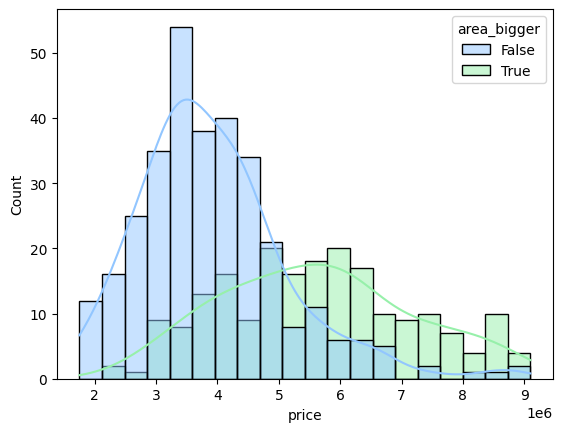

In [319]:
df_area = df.copy()
df_area['area_bigger'] = df_area['area'] > 5250

sns.histplot(
    data=df_area,
    x="price",
    bins=20,
    kde=True,
    hue='area_bigger'
)

In [320]:
# It is true, the houses with a larger area usually tend to have a higher price

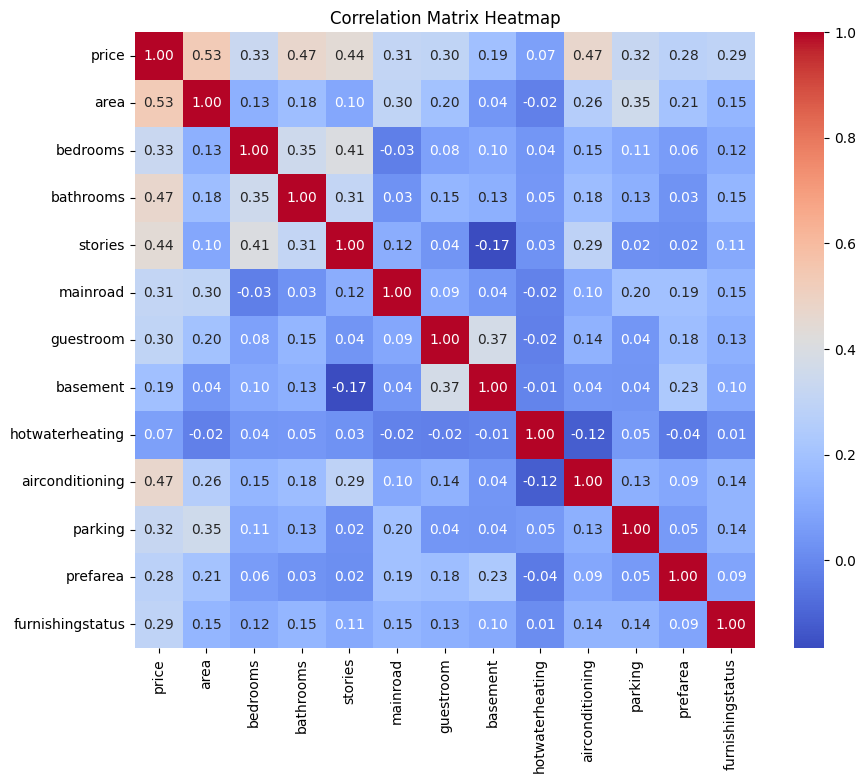

In [321]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [322]:
# As we can observe, there is a positive correlation between price and: area,
# bathrooms, stories and airconditioning
# There is also correlation between parking and area; bedrooms and: bathrooms,
# stories; basement and guestroom(strange one)

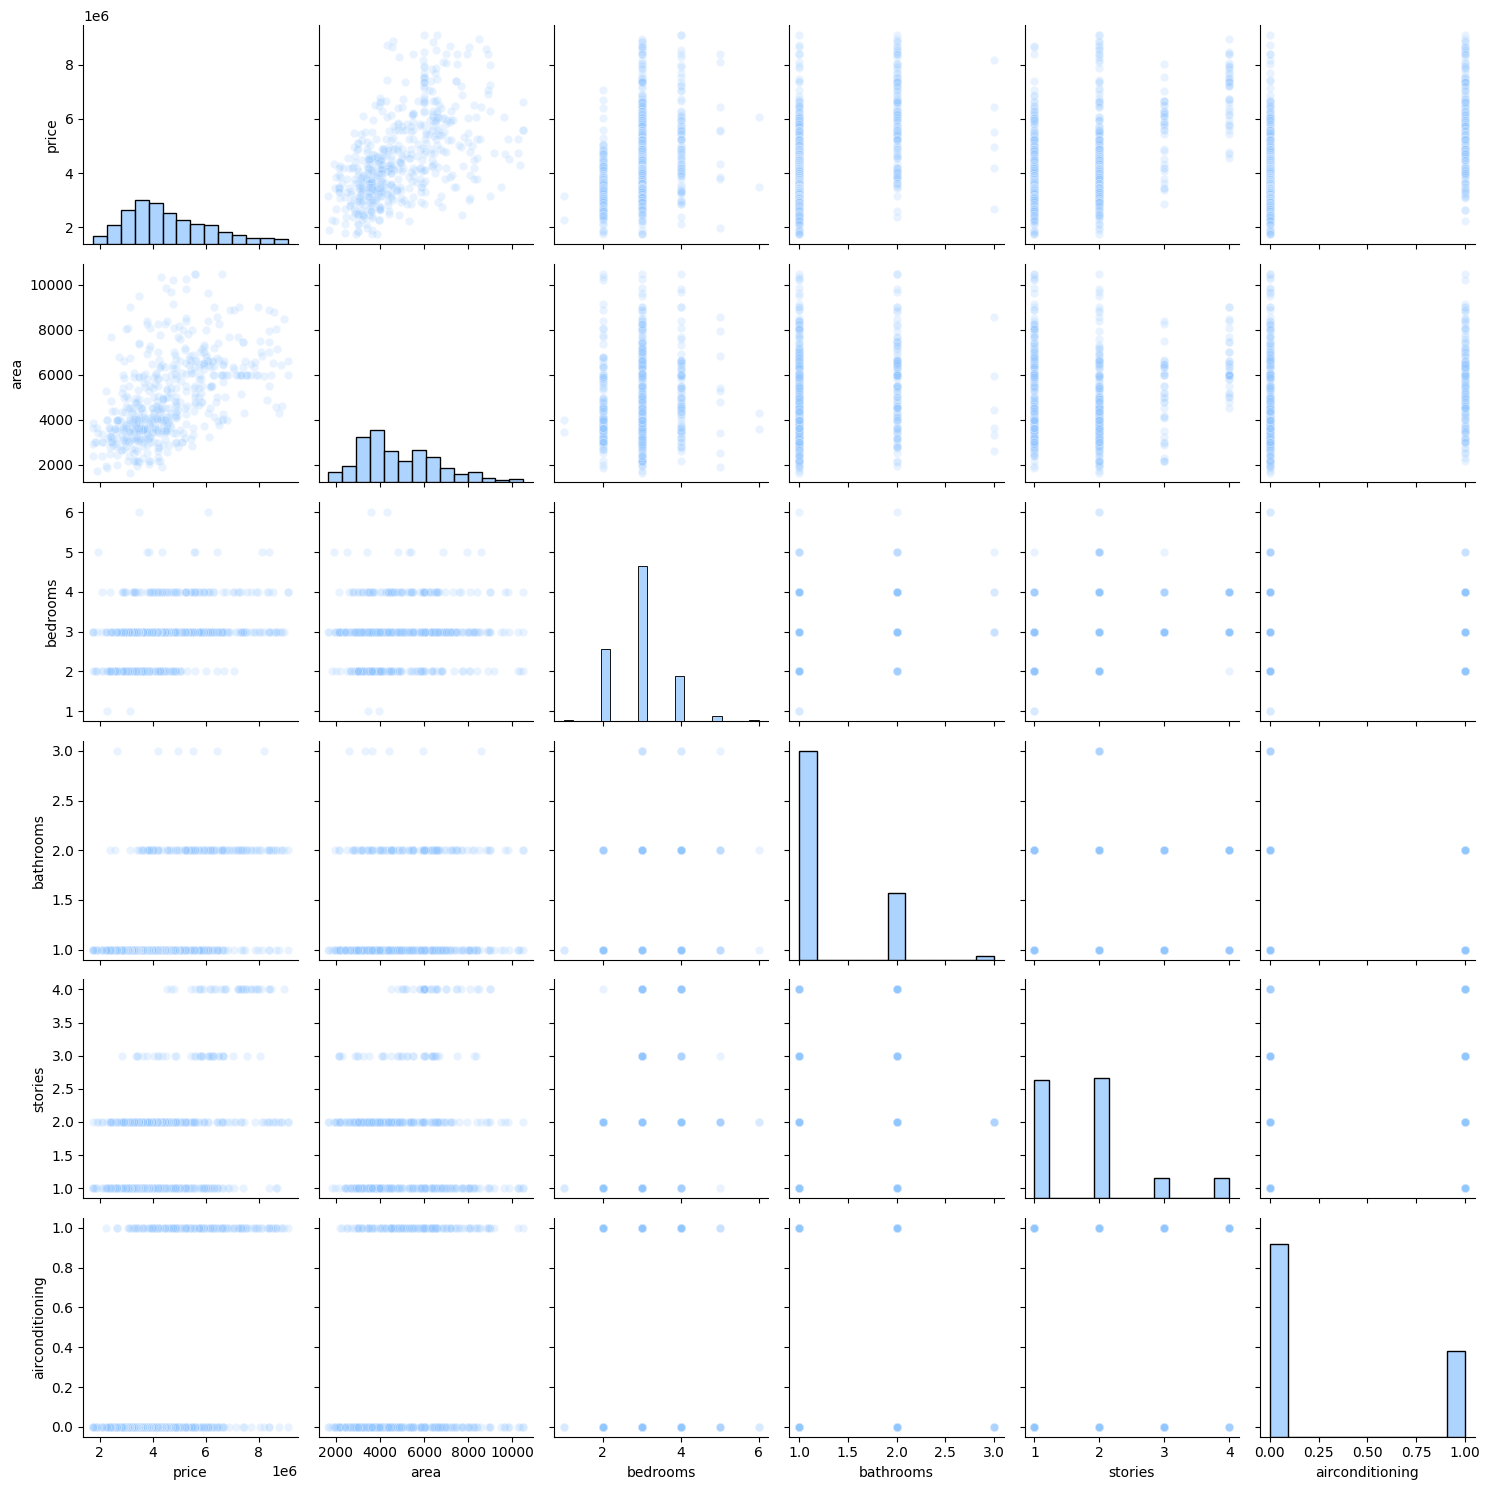

In [323]:
sns.pairplot(df[['price','area','bedrooms','bathrooms','stories','airconditioning']], diag_kind='auto', plot_kws={'alpha': 0.2}, dropna=True)
plt.tight_layout()
plt.show()

In [324]:
# We see the same thing there. Area and price show something similar to a line

In [ ]:
# Based on EDA, I suppose that a great model will be LinearRegression
# Also, I would like to try DecisionTreeRegressor, RandomForestRegressor, and
# XGBoostRegressor, because as we saw from the correlation matrix, there are not
# linear correlations between values.

# ML

In [ ]:
# Let's start with a simple LinearRegression
# We want to predict price based on all other columns
# We split the data into train and test to train our model, and then to validate
# predictions.

In [325]:
X = df.drop('price', axis=1).copy()
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 45)

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print(f'Train R2 {r2_score(y_train, pred_train):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test):.2f}')
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

Train R2 0.66
Test R2 0.67
MAE: 650215.2115985453
RMSE: 844444.1946284246


In [326]:
# The results are moderate, but lets' analyze other models

In [ ]:
# The next one is DecisionTreeRegressor

In [395]:
tree_1 = DecisionTreeRegressor(
    random_state=42,
    max_depth=8,
    min_samples_leaf=8,
    min_samples_split=10
)
tree_1.fit(X_train, y_train)

pred_train = tree_1.predict(X_train)
pred_test = tree_1.predict(X_test)

print(f'Train R2 {r2_score(y_train, pred_train):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test):.2f}')
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

Train R2 0.70
Test R2 0.58
MAE: 742728.5513231427
RMSE: 959062.7974235796


In [ ]:
# I "played" a little bit with parameters and it gave me the best results
# Suprisingly, it performs worse than linear regression

In [ ]:
# The next one to try is RandomForestRegressor
# I also have "played" a little bit with its' parameters

In [331]:
random_forest = RandomForestRegressor(
    n_estimators=70,
    max_depth=7,
    random_state=42,
    max_features="sqrt",
)
random_forest.fit(X_train, y_train)

pred_train = random_forest.predict(X_train)
pred_test = random_forest.predict(X_test)

print(f'Train R2 {r2_score(y_train, pred_train):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test):.2f}')
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

Train R2 0.84
Test R2 0.69
MAE: 620841.1082220505
RMSE: 828432.9278877206


In [332]:
# The results are better than in the previous one, it is already 0.69!
# Also, MAE and RMSE dropped significantly!

In [333]:
# Let's try to analyze features' importances

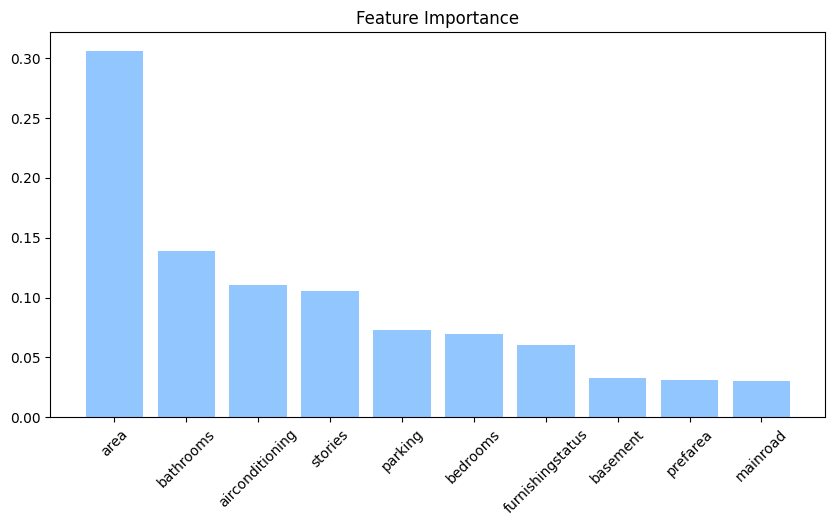

In [334]:
rc('font', family='DejaVu Sans')

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), X.columns[indices[:10]], rotation=45)
plt.title("Feature Importance")
plt.show()


In [335]:
# Let's exclude the two last significant

In [336]:
random_forest = RandomForestRegressor(
    n_estimators=70,
    max_depth=7,
    random_state=42,
    max_features="sqrt",
)

random_forest.fit(X_train.drop(['mainroad','prefarea'], axis=1), y_train)

pred_train = random_forest.predict(X_train.drop(['mainroad','prefarea'], axis=1))
pred_test = random_forest.predict(X_test.drop(['mainroad','prefarea'], axis=1))

print(f'Train R2 {r2_score(y_train, pred_train):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test):.2f}')
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

Train R2 0.84
Test R2 0.62
MAE: 697281.8454337597
RMSE: 908609.305007934


In [337]:
# Suprisingly, the results on test have dropped

In [ ]:
# The last one to try is XGBoostRegressor
# I also needed to adjust parameters to get the best results

In [338]:
xgboost = xgb.XGBRegressor(
    n_estimators=14,
    max_depth=4,
    random_state=42,
    reg_lambda=30
)

xgboost.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)

pred_train = xgboost.predict(X_train)
pred_test = xgboost.predict(X_test)

print(f'Train R2 {r2_score(y_train, pred_train):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test):.2f}')
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

Train R2 0.75
Test R2 0.69
MAE: 630153.9375
RMSE: 828633.2471630619


In [339]:
# It performs quite well, both on training and test data.
# However, its results on training are worse than RandomForestRegression.
# But, it is a good thing - it means that it is not as overfitted as
# RandomForestRegression was.

In [340]:
# Next, let's try to scale data and train linear regression one more time

In [341]:
mms = MinMaxScaler()
mms.fit(X_train)

MinMaxScaler()

In [342]:
cols_to_scale = ['stories', 'parking', 'area']

mms.fit(X_train[cols_to_scale])

scaled_part = pd.DataFrame(
    mms.transform(X_train[cols_to_scale]),
    columns=cols_to_scale,
    index=X_train.index
)

unscaled_part = X_train[['mainroad', 'guestroom', 'basement',
                 'hotwaterheating', 'airconditioning',
                 'prefarea', 'furnishingstatus']]

X_train_norm = pd.concat([unscaled_part, scaled_part], axis=1)

X_train_norm.describe()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus,stories,parking,area
count,416.000,416.000,416.000,416.000,416.000,416.000,416.000,416.000,416.000,416.000
mean,0.861,0.185,0.332,0.043,0.317,0.207,0.452,0.270,0.231,0.374
std,0.347,0.389,0.471,0.204,0.466,0.405,0.382,0.294,0.284,0.206
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.218
50%,1.000,0.000,0.000,0.000,0.000,0.000,0.500,0.333,0.000,0.318
75%,1.000,0.000,1.000,0.000,1.000,0.000,0.500,0.333,0.333,0.500
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [343]:
# We scale only columns which are not yet holding values between [0;1]

In [344]:
scaled_test = pd.DataFrame(
    mms.transform(X_test[cols_to_scale]),
    columns=cols_to_scale,
    index=X_test.index
)

X_test_norm = pd.concat([X_test[['mainroad', 'guestroom', 'basement',
                 'hotwaterheating', 'airconditioning',
                 'prefarea', 'furnishingstatus']], scaled_test], axis=1)

X_test_norm.describe()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus,stories,parking,area
count,104.000,104.000,104.000,104.000,104.000,104.000,104.000,104.000,104.000,104.000
mean,0.817,0.144,0.404,0.038,0.269,0.260,0.466,0.240,0.170,0.335
std,0.388,0.353,0.493,0.193,0.446,0.441,0.370,0.265,0.263,0.210
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.006
25%,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161
50%,1.000,0.000,0.000,0.000,0.000,0.000,0.500,0.333,0.000,0.302
75%,1.000,0.000,1.000,0.000,1.000,1.000,0.500,0.333,0.333,0.490
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.830


In [345]:
# We scale test separately in order to prevent data leakage

In [346]:
lr = LinearRegression()
lr.fit(X_train_norm, y_train)

pred_train = lr.predict(X_train_norm)
pred_test = lr.predict(X_test_norm)

print(f'Train R2 {r2_score(y_train, pred_train):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test):.2f}')
print("MAE:", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))

Train R2 0.62
Test R2 0.58
MAE: 723021.0153924817
RMSE: 960363.1987054112


In [347]:
# Oh, as we see, the results dropped, so the problem wasn't the scale of the data

In [348]:
# This project aimed to predict housing prices using the provided dataset. The
# process followed a standard Machine Learning pipeline: data cleaning, exploratory
# analysis, feature transformation, model training, and evaluation.

# So, at first we cleaned the data, ensured that there are no missing values and
# transformed object-valued columns into numeric ones. Then, we analyzed the
# distribution and got rid of outliers. Next, we looked at the correlation between
# columns(I tried to train linear regression on mostly correlated columns, but it
# performed so bad that I haven't kept it). It suggests the relationship between
# the features and price is complex and non-linear.

# Overall, we trained several simple models. All of them have performed moderately.
# The best model was XGBoost, and then RandomForestRegressor. We have worked a
# little bit on parameters to enhance our results and it worked out well!
# Our assumptions of models have not been fully approved, because LinearRegression
# wasn't performing as well as RandomForestRegressor and XGBoost. But, those two
# showed a pretty good r2_score of 0.69, confirming that non-linear, tree-based
# algorithms are better suited for capturing the complexity and interactions
# within this housing price dataset.